In [2]:
import torch
import random
from os import path
import scanpy as sc
import squidpy as sq
import scipy.sparse as sp
import numpy as np
from sklearn.decomposition import NMF
import gpzoo.pri_experiment_utilities as exp
from torch import nn
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [132]:
random.seed(256)
root_path = '/engelhardt/home/pshrestha/spatial_gradients_project/'
dtp = "float32"
dpath = path.join(root_path, "data/")

In [133]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2
Current GPU:  0
GPU Name:  NVIDIA A30


In [134]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
device

device(type='cpu')

In [135]:
saved_model = path.join(root_path, 'models/glioblastoma_sigma=0.03_ls=0.05_k=8.pth')

In [136]:
# make model
adata = sc.read_visium(dpath)
adata.var_names_make_unique()

# Convert sparse matrix to dense first
adata.X = adata.X.toarray() if sp.issparse(adata.X) else adata.X

Y_sums = np.array(np.sum(adata.X > 0, axis=0)).flatten()  
Y = adata.X[:, Y_sums > 100]
X = adata.obsm['spatial']

L = 10
max_iter = 100
nmf_model = NMF(n_components=L, max_iter=max_iter, init='nndsvd', random_state=0, alpha_H=2e-1, alpha_W=1e-7)
nmf_model.fit(Y)
exp_factors = nmf_model.transform(Y)
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

moran_idx, moranI = exp.dims_autocorr(np.exp(factors), X)

factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

model_type = 'VNNGP'

dicts = {
    'L': L, 
    'M': X.shape[0], 
    'K': 8,
    'sigma': 0.03, 
    'lengthscale': 0.05, 
    'jtr': 1e-1,
    'batch_size': 128,
    'lr': 1e-3,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter' : 1e-3,
}
            
factors = np.array(factors_ordered)
loadings = np.array(loadings_ordered)

X = np.array(X, np.float64)
Y = np.array(Y, np.float64)


# Min Max Rescaling
X_min = X.min()
X_max = X.max()
X = (X - X_min) / (X_max - X_min)

model = exp.build_model(X, Y.T, loadings=loadings, factors=factors, model_type=model_type, kwargs=dicts)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [137]:
model.load_state_dict(torch.load(saved_model, map_location=torch.device("cpu")))
model.eval()

NSF2(
  (prior): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [138]:
qF, _, _ = model.prior(torch.tensor(X, dtype=torch.float).to(device), kwargs=dicts)

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/gp.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()


In [139]:
mean = torch.exp(qF.mean).detach().numpy()

In [140]:
print(X.shape)
print(Y.shape)

(1937, 2)
(1937, 10607)


In [141]:
W = (model.W).cpu()

In [142]:
W_transformed = nn.functional.softplus(W.T)
W_transformed = W_transformed.detach().numpy()

In [143]:
print(f"Mean shape: {mean.shape}")
print(f"W shape: {W_transformed.shape}")

Mean shape: (10, 1937)
W shape: (10, 10607)


In [144]:
mean

array([[ 0.994607  ,  0.9946205 , 13.955504  , ...,  0.99506444,
         5.4860454 , 15.083513  ],
       [ 0.9931988 ,  3.5124085 ,  1.180289  , ...,  1.9932927 ,
         0.99396306,  1.4908901 ],
       [ 2.384976  ,  9.071233  ,  0.9960126 , ...,  2.239967  ,
         0.99618125,  0.9952274 ],
       ...,
       [ 0.99430996,  1.4742306 ,  1.1619978 , ...,  1.9078251 ,
         1.8454535 ,  1.7913945 ],
       [ 2.983416  ,  0.99790084,  1.4855527 , ...,  1.4065804 ,
         4.082385  ,  1.1844251 ],
       [ 1.0001367 ,  1.0000106 ,  0.9999923 , ...,  1.0001041 ,
         0.9998172 ,  1.0000719 ]], dtype=float32)

In [145]:
W_transformed

array([[1.23316580e-02, 7.81536382e-03, 7.06825778e-03, ...,
        1.53641850e-01, 9.99995336e-06, 7.46199721e-03],
       [2.92525925e-02, 3.94998528e-02, 3.05449329e-02, ...,
        1.47508517e-01, 4.73282207e-03, 1.09146698e-03],
       [6.00970956e-03, 1.47001818e-02, 2.24627964e-02, ...,
        7.51369298e-02, 2.99848826e-03, 9.99995336e-06],
       ...,
       [8.05911049e-03, 3.67702311e-03, 1.70635805e-02, ...,
        5.75836003e-02, 5.17717144e-03, 1.51104210e-02],
       [6.11931132e-03, 1.59505717e-02, 7.03925593e-03, ...,
        9.78938043e-02, 5.00182738e-04, 9.99995336e-06],
       [9.39152786e-04, 9.99995336e-06, 9.99995336e-06, ...,
        1.03508435e-01, 8.02730303e-03, 9.99995336e-06]], dtype=float32)

In [146]:
# gradient calculation
# 1937 spatial locations
# 10607 genes at each location

# first focus on one factor
meanf = mean[0]
Wf = W_transformed[0]

In [147]:
print(meanf.shape)
print(Wf.shape)

(1937,)
(10607,)


In [148]:
Wf

array([1.2331658e-02, 7.8153638e-03, 7.0682578e-03, ..., 1.5364185e-01,
       9.9999534e-06, 7.4619972e-03], dtype=float32)

In [149]:
X_unscaled = adata.obsm['spatial']
X_unscaled

array([[5769, 4461],
       [5555, 5285],
       [2584, 3865],
       ...,
       [4692, 3039],
       [3188, 5063],
       [2541, 4090]])

In [150]:
# Minimum and maximum x values (first column)
min_x = np.min(X_unscaled[:, 0])
max_x = np.max(X_unscaled[:, 0])

# Minimum and maximum y values (second column)
min_y = np.min(X_unscaled[:, 1])
max_y = np.max(X_unscaled[:, 1])

print(f"Min x: {min_x}, Max x: {max_x}")
print(f"Min y: {min_y}, Max y: {max_y}")

Min x: 1936, Max x: 6756
Min y: 1464, Max y: 5811


In [151]:
# Find the indices for min x, min y, max x, max y
min_x_coord = X_unscaled[np.argmin(X_unscaled[:, 0])]
max_x_coord = X_unscaled[np.argmax(X_unscaled[:, 0])]
min_y_coord = X_unscaled[np.argmin(X_unscaled[:, 1])]
max_y_coord = X_unscaled[np.argmax(X_unscaled[:, 1])]

# Display the results
print(f"Coordinate with min x: {min_x_coord}")
print(f"Coordinate with max x: {max_x_coord}")
print(f"Coordinate with min y: {min_y_coord}")
print(f"Coordinate with max y: {max_y_coord}")

Coordinate with min x: [1936 2593]
Coordinate with max x: [6756 1539]
Coordinate with min y: [6541 1464]
Coordinate with max y: [4221 5811]


In [152]:
# Sort the data by x-coordinate for easier traversal
sorted_X = X_unscaled[np.lexsort((X_unscaled[:, 1], X_unscaled[:, 0]))]

In [153]:
def get_closest_unique(candidate_points, point, used_points):
    """
    Finds the closest unique neighbor from a list of candidates.
    If a duplicate is selected, chooses the second closest instead.
    
    Parameters:
    - candidate_points: NumPy array of candidate points.
    - point: The original point (x, y).
    - used_points: Set of already selected neighbors (to enforce uniqueness).

    Returns:
    - The closest unique point or None if no valid neighbor exists.
    """
    if len(candidate_points) == 0:
        return None

    distances = np.linalg.norm(candidate_points - point, axis=1)  # Compute distances
    sorted_indices = np.argsort(distances)  # Sort indices by closest distance

    # Find the closest unique point
    for idx in sorted_indices:
        neighbor = tuple(candidate_points[idx])  # Convert to tuple for uniqueness check
        if neighbor not in used_points:
            used_points.add(neighbor)
            return np.array(neighbor)  # Convert back to NumPy array
    
    return None  # If no unique neighbor found


def find_closest_neighbors(point, data):
    """
    Finds the top, bottom, left, and right neighbors of a given point,
    ensuring uniqueness and that left/right neighbors have the same y-coordinate.
    
    Parameters:
    - point: The target point (x, y).
    - data: NumPy array of all spatial points (N, 2).

    Returns:
    - A tuple of (top_neighbor, bottom_neighbor, left_neighbor, right_neighbor).
    """
    x, y = point

    # Get candidates for each direction
    top = data[data[:, 1] > y]      # Points above (y greater)
    bottom = data[data[:, 1] < y]   # Points below (y smaller)
    left = data[(data[:, 0] < x)]  # Left with same y
    right = data[(data[:, 0] > x)]  # Right with same y

    # Track selected neighbors to ensure uniqueness
    used_neighbors = set()

    # Find unique closest neighbors
    left_neighbor = get_closest_unique(left, point, used_neighbors)
    right_neighbor = get_closest_unique(right, point, used_neighbors)
    top_neighbor = get_closest_unique(top, point, used_neighbors)
    bottom_neighbor = get_closest_unique(bottom, point, used_neighbors)

    return top_neighbor, bottom_neighbor, left_neighbor, right_neighbor


In [174]:
def find_k_nearest_neighbors(point, data, tree, k):
    """
    Finds the k nearest top, bottom, left, and right neighbors of a given point.
    
    Parameters:
    - point: Target point (x, y).
    - data: NumPy array of all spatial points (N, 2).
    - tree: cKDTree object for fast neighbor search.
    - k: Number of neighbors to find in each direction.

    Returns:
    - A tuple of lists: (top_neighbors, bottom_neighbors, left_neighbors, right_neighbors).
    """
    x, y = point
    
    # Compute distances and indices to the k nearest points
    distances, indices = tree.query(point, k + 1)  # k + 1 to ignore the point itself
    
    neighbors = data[indices[1:]]  # Ignore the first index since it's the point itself
    
    # Find top, bottom, left, and right neighbors
    top = neighbors[neighbors[:, 1] > y][:k]
    bottom = neighbors[neighbors[:, 1] < y][:k]
    left = neighbors[neighbors[:, 0] < x][:k]
    right = neighbors[neighbors[:, 0] > x][:k]

    # Ensure exactly k neighbors (pad with closest points if needed)
    if len(top) < k:
        top = np.vstack([top, neighbors[neighbors[:, 1] > y][:k - len(top)]])
    if len(bottom) < k:
        bottom = np.vstack([bottom, neighbors[neighbors[:, 1] < y][:k - len(bottom)]])
    if len(left) < k:
        left = np.vstack([left, neighbors[neighbors[:, 0] < x][:k - len(left)]])
    if len(right) < k:
        right = np.vstack([right, neighbors[neighbors[:, 0] > x][:k - len(right)]])
    
    # Get indices of the neighbors
    top_indices = [np.where((data == t).all(axis=1))[0][0] for t in top]
    bottom_indices = [np.where((data == b).all(axis=1))[0][0] for b in bottom]
    left_indices = [np.where((data == l).all(axis=1))[0][0] for l in left]
    right_indices = [np.where((data == r).all(axis=1))[0][0] for r in right]

    return top_indices, bottom_indices, left_indices, right_indices

In [154]:
sorted_X = X_unscaled[np.lexsort((X_unscaled[:, 0], X_unscaled[:, 1]))]

In [155]:
sorted_X[:20]

array([[6369, 1464],
       [6455, 1464],
       [6541, 1464],
       [6067, 1539],
       [6240, 1539],
       [6326, 1539],
       [6412, 1539],
       [6498, 1539],
       [6584, 1539],
       [6670, 1539],
       [6756, 1539],
       [6111, 1614],
       [6369, 1614],
       [6455, 1614],
       [6541, 1614],
       [6627, 1614],
       [6713, 1614],
       [5766, 1615],
       [5852, 1615],
       [6670, 1688]])

In [156]:
# Test the function on the top-left most point
start_point = sorted_X[2]
neighbors = find_closest_neighbors(start_point, sorted_X)

print(f"Starting point: {start_point}")
print(f"Top neighbor: {neighbors[0]}")
print(f"Bottom neighbor: {neighbors[1]}")
print(f"Left neighbor: {neighbors[2]}")
print(f"Right neighbor: {neighbors[3]}")

Starting point: [6541 1464]
Top neighbor: [6498 1539]
Bottom neighbor: None
Left neighbor: [6455 1464]
Right neighbor: [6584 1539]


In [157]:
# Plotting function
def plot_neighbors(data, point, neighbors):
    plt.figure(figsize=(10, 8))
    plt.scatter(data[:, 0], data[:, 1], label='All Points', alpha=0.6)
    
    # Plot the original point
    plt.scatter(point[0], point[1], color='red', label='Original Point', s=90)
    
    # Plot the neighbors
    for i, neighbor in enumerate(neighbors):
        if neighbor is not None:
            plt.scatter(neighbor[0], neighbor[1], label=f'Neighbor {i+1}', s=60)
    
    plt.title('Sanity Check: Neighbors for a Random Test Point')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()


Test Point: [5681 2064]
Neighbors (top, bottom, left, right): (array([5724, 2139]), array([5724, 1989]), array([5595, 2064]), array([5767, 2064]))


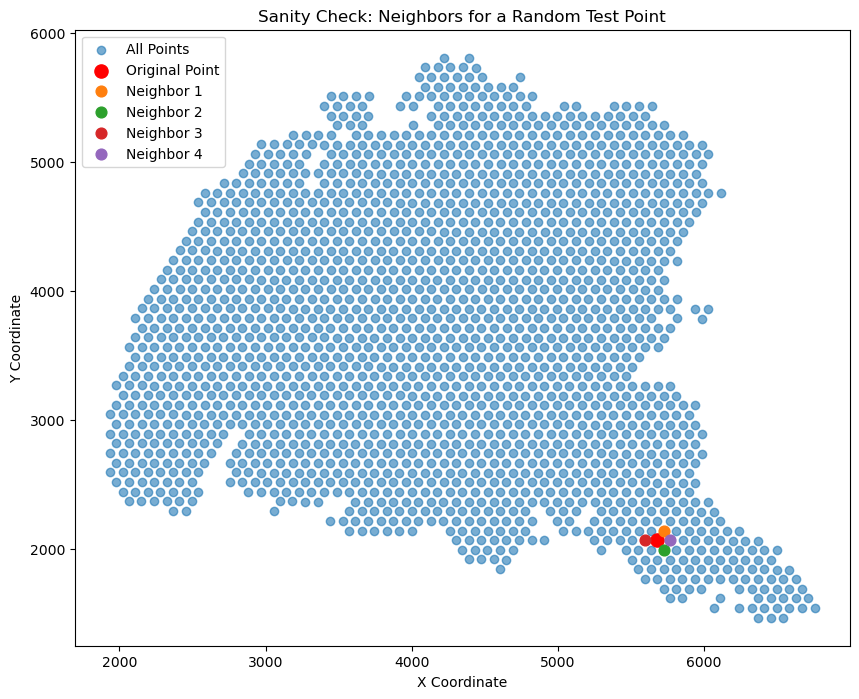


Test Point: [4691 2290]
Neighbors (top, bottom, left, right): (array([4648, 2365]), array([4648, 2215]), array([4605, 2290]), array([4777, 2290]))


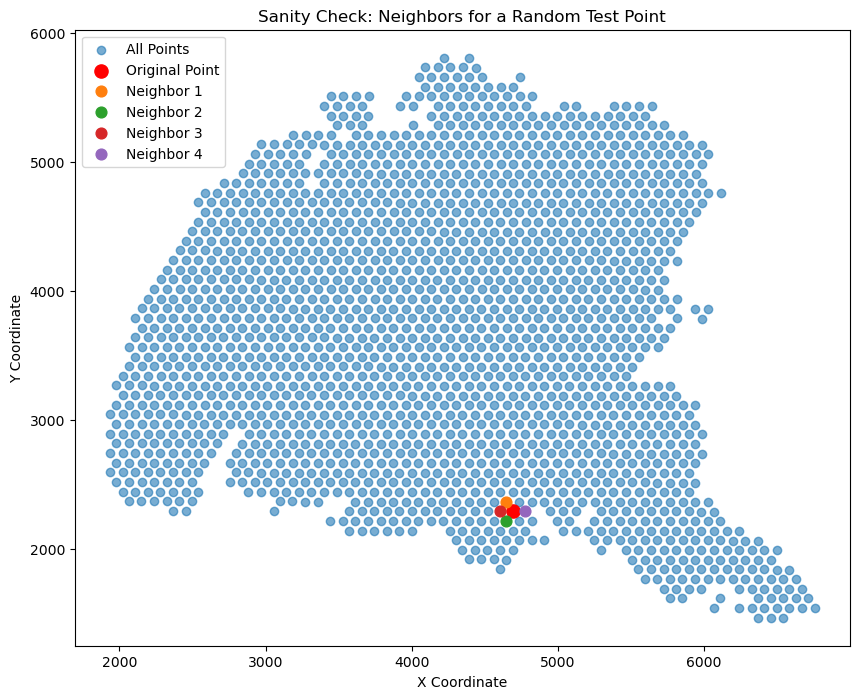


Test Point: [3659 2890]
Neighbors (top, bottom, left, right): (array([3702, 2965]), array([3615, 2815]), array([3616, 2965]), array([3701, 2815]))


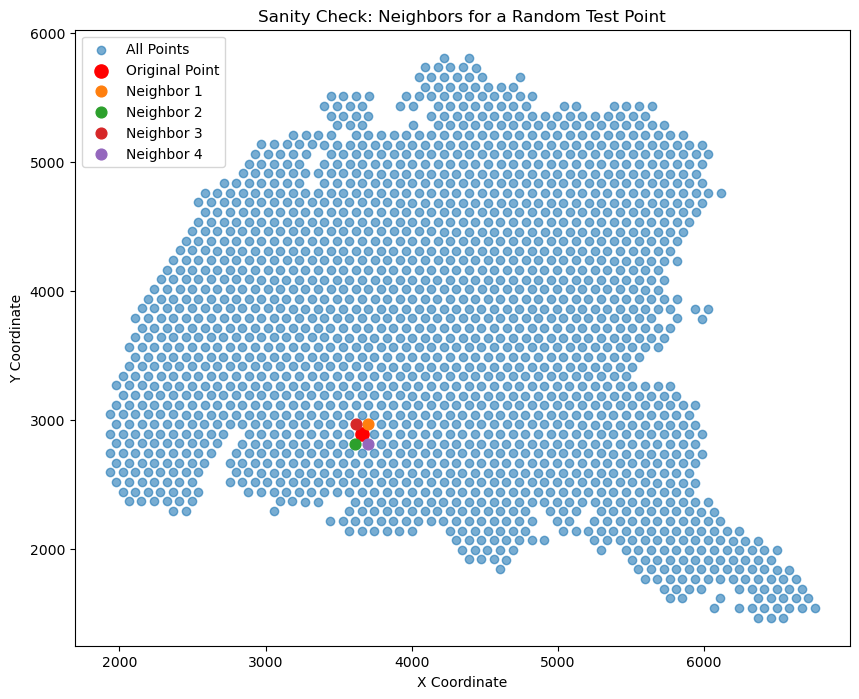


Test Point: [4520 3488]
Neighbors (top, bottom, left, right): (array([4434, 3489]), array([4391, 3414]), array([4477, 3414]), array([4563, 3414]))


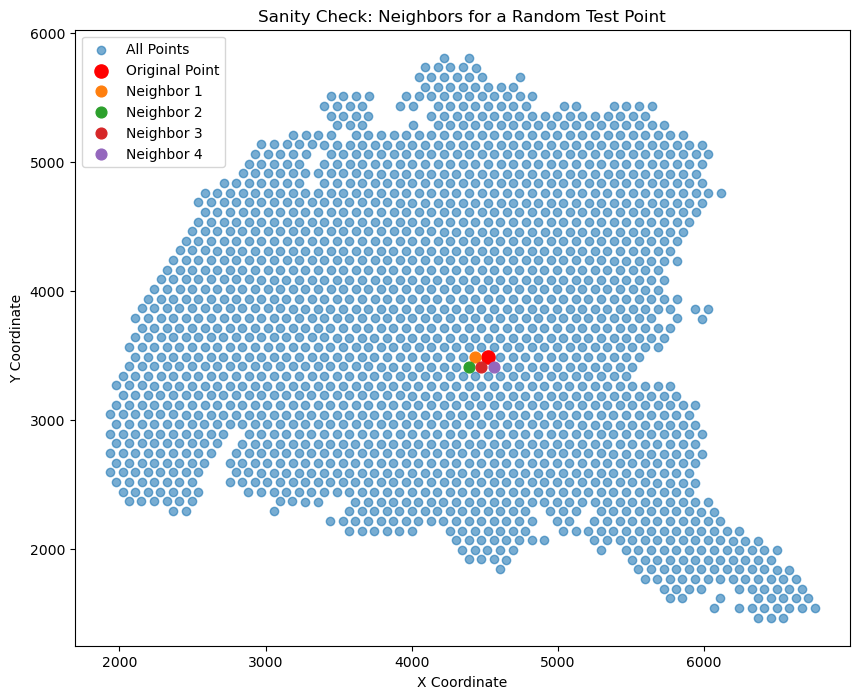


Test Point: [3919 4837]
Neighbors (top, bottom, left, right): (array([3962, 4912]), array([3876, 4762]), array([3833, 4837]), array([4005, 4837]))


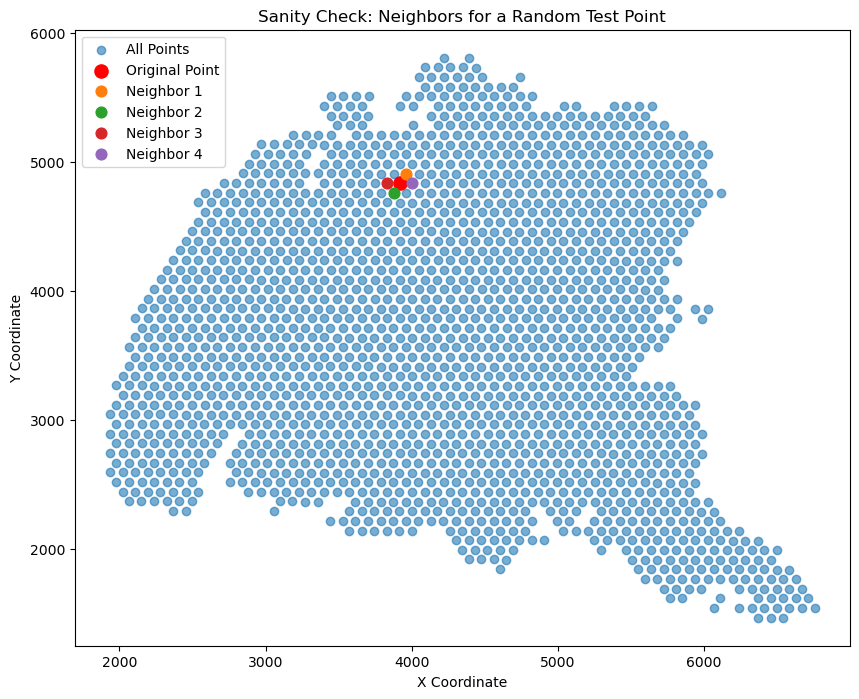

In [158]:
# Sanity check for 5 randomly selected points
np.random.seed(42)  # Ensure reproducibility
random_indices = np.random.choice(len(X_unscaled), size=5, replace=False)

for idx in random_indices:
    test_point = X_unscaled[idx]
    neighbors = find_closest_neighbors(test_point, X_unscaled)
    print(f"\nTest Point: {test_point}")
    print(f"Neighbors (top, bottom, left, right): {neighbors}")
    plot_neighbors(X_unscaled, test_point, neighbors)


Test Point: [5681 2064]
Neighbors: (array([5724, 2139]), array([5724, 1989]), array([5595, 2064]), array([5767, 2064]))

Test Point: [4691 2290]
Neighbors: (array([4648, 2365]), array([4648, 2215]), array([4605, 2290]), array([4777, 2290]))

Test Point: [3659 2890]
Neighbors: (array([3702, 2965]), array([3615, 2815]), array([3616, 2965]), array([3701, 2815]))

Test Point: [4520 3488]
Neighbors: (array([4434, 3489]), array([4391, 3414]), array([4477, 3414]), array([4563, 3414]))

Test Point: [3919 4837]
Neighbors: (array([3962, 4912]), array([3876, 4762]), array([3833, 4837]), array([4005, 4837]))


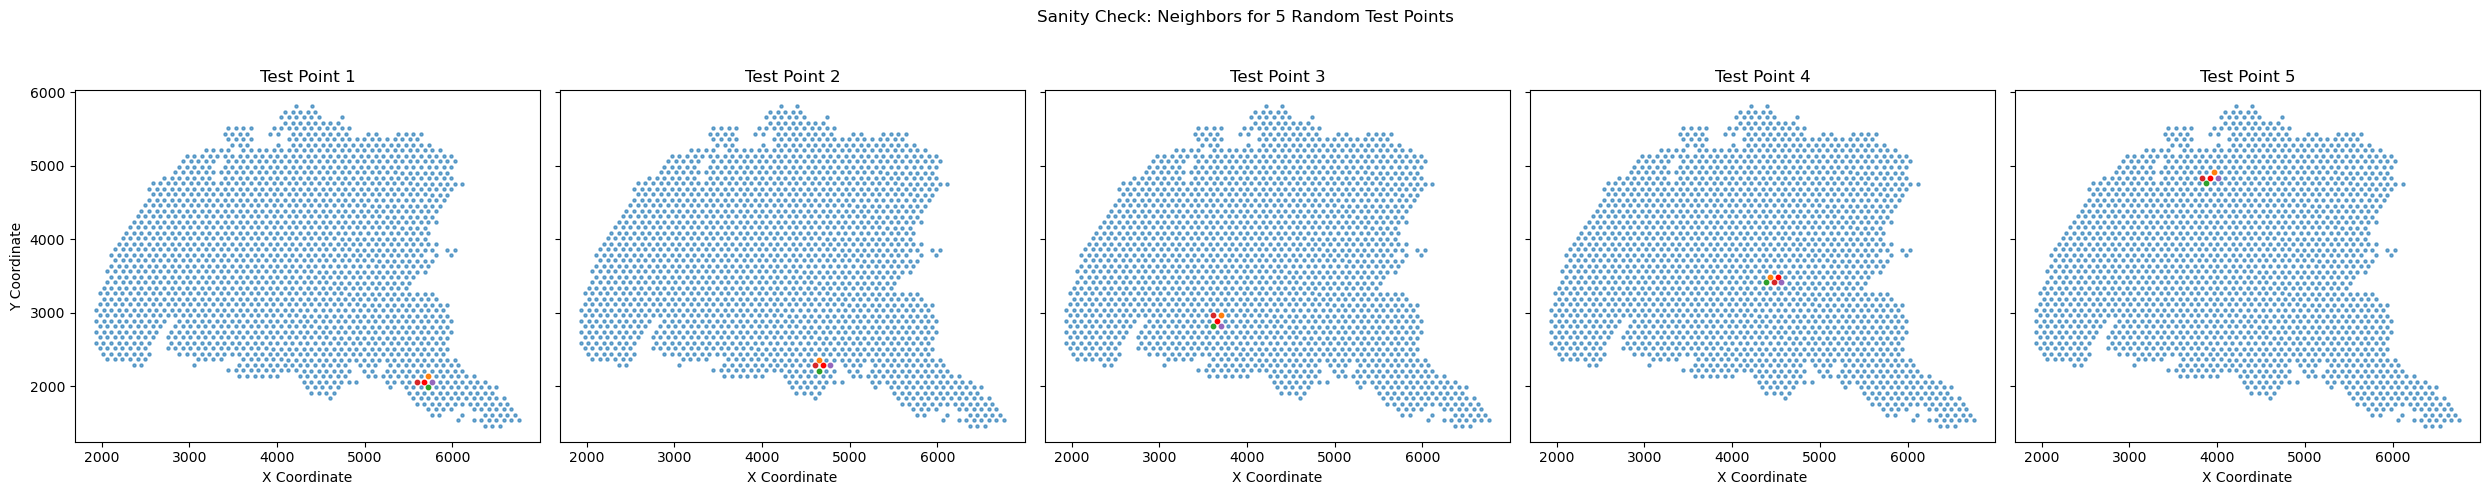

In [159]:
# Plotting function for 5 subplots in one row
np.random.seed(42)  # Ensure reproducibility
random_indices = np.random.choice(len(X_unscaled), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

for i, idx in enumerate(random_indices):
    test_point = X_unscaled[idx]
    neighbors = find_closest_neighbors(test_point, X_unscaled)
    print(f"\nTest Point: {test_point}")
    print(f"Neighbors: {neighbors}")
    
    ax = axes[i]
    ax.scatter(X_unscaled[:, 0], X_unscaled[:, 1], label='All Points', alpha=0.6, s=5)
    ax.scatter(test_point[0], test_point[1], color='red', label='Test Point', s=10)
    
    for neighbor in neighbors:
        if neighbor is not None:
            ax.scatter(neighbor[0], neighbor[1], label='Neighbor', s=10)
    
    ax.set_title(f'Test Point {i+1}')
    ax.set_xlabel('X Coordinate')
    if i == 0:
        ax.set_ylabel('Y Coordinate')

plt.suptitle('Sanity Check: Neighbors for 5 Random Test Points')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [160]:
# first focus on one factor
meanf = mean[0]
Wf = W_transformed[0]

In [161]:
print(meanf.shape)
print(Wf.shape)

(1937,)
(10607,)


In [162]:
print(W_transformed.shape)
print(mean.shape)

(10, 10607)
(10, 1937)


In [163]:
output = (W_transformed.T).dot(mean)

In [164]:
output.shape

(10607, 1937)

In [165]:
def compute_spatial_gradients(expression_matrix, coordinates):
    """
    Computes the spatial gradients in the x and y directions for each gene.
    
    Parameters:
    - expression_matrix: NumPy array of shape (num_gene, num_coordinates), gene expression values.
    - coordinates: NumPy array of shape (num_coordinates, 2), spatial coordinates (x, y).

    Returns:
    - gradient_matrix: NumPy array of shape (2*num_gene, num_valid_points), spatial gradients.
    """
    num_gene, num_coordinates = expression_matrix.shape

    # Find valid indices and neighbors
    valid_indices = []
    neighbor_indices = []  # Stores (left, right, top, bottom) for valid points

    # Create a dictionary for fast lookup
    coord_dict = {tuple(coordinates[i]): i for i in range(num_coordinates)}

    for i, point in enumerate(coordinates):
        top, bottom, left, right = find_closest_neighbors(point, coordinates)

        # Ensure all four neighbors exist
        if top is not None and bottom is not None and left is not None and right is not None:
            valid_indices.append(i)
            neighbor_indices.append((
                coord_dict[tuple(left)], coord_dict[tuple(right)],
                coord_dict[tuple(top)], coord_dict[tuple(bottom)]
            ))

    # Convert to NumPy arrays for efficient processing
    valid_indices = np.array(valid_indices)
    neighbor_indices = np.array(neighbor_indices)

    # Compute gradients
    gradient_x = np.zeros((num_gene, len(valid_indices)))
    gradient_y = np.zeros((num_gene, len(valid_indices)))

    for idx, i in enumerate(valid_indices):
        left_idx, right_idx, top_idx, bottom_idx = neighbor_indices[idx]

        # Compute gradients for each gene
        gradient_x[:, idx] = (expression_matrix[:, right_idx] - expression_matrix[:, left_idx]) / 2
        gradient_y[:, idx] = (expression_matrix[:, top_idx] - expression_matrix[:, bottom_idx]) / 2

    # Concatenate x and y gradients to get final shape (2*num_gene, num_valid_points)
    gradient_matrix = np.vstack((gradient_x, gradient_y))
    
    return gradient_matrix


In [166]:
def compute_spatial_gradients_with_coords(expression_matrix, coordinates):
    """
    Computes the spatial gradients in the x and y directions for each gene.
    
    Parameters:
    - expression_matrix: NumPy array of shape (num_gene, num_coordinates), gene expression values.
    - coordinates: NumPy array of shape (num_coordinates, 2), spatial coordinates (x, y).

    Returns:
    - valid_coords: Coordinates where gradients are computed (shape = (num_valid_points, 2))
    - gradient_x: X-direction gradients (shape = (num_gene, num_valid_points))
    - gradient_y: Y-direction gradients (shape = (num_gene, num_valid_points))
    """
    num_gene, num_coordinates = expression_matrix.shape

    # Find valid indices and neighbors
    valid_indices = []
    neighbor_indices = []  # Stores (left, right, top, bottom) for valid points

    # Create a dictionary for fast lookup
    coord_dict = {tuple(coordinates[i]): i for i in range(num_coordinates)}

    for i, point in enumerate(coordinates):
        top, bottom, left, right = find_closest_neighbors(point, coordinates)

        # Ensure all four neighbors exist
        if top is not None and bottom is not None and left is not None and right is not None:
            valid_indices.append(i)
            neighbor_indices.append((
                coord_dict[tuple(left)], coord_dict[tuple(right)],
                coord_dict[tuple(top)], coord_dict[tuple(bottom)]
            ))

    # Convert to NumPy arrays for efficient processing
    valid_indices = np.array(valid_indices)
    neighbor_indices = np.array(neighbor_indices)

    # Compute gradients
    gradient_x = np.zeros((num_gene, len(valid_indices)))
    gradient_y = np.zeros((num_gene, len(valid_indices)))

    for idx, i in enumerate(valid_indices):
        left_idx, right_idx, top_idx, bottom_idx = neighbor_indices[idx]

        # Compute gradients for each gene
        gradient_x[:, idx] = (expression_matrix[:, right_idx] - expression_matrix[:, left_idx]) / 2
        gradient_y[:, idx] = (expression_matrix[:, top_idx] - expression_matrix[:, bottom_idx]) / 2

    # Get valid coordinates (for plotting)
    valid_coords = coordinates[valid_indices]

    return valid_coords, gradient_x, gradient_y

In [167]:
X_norm = (sorted_X - sorted_X.min(axis=0)) / (sorted_X.max(axis=0) - sorted_X.min(axis=0))

In [168]:
valid_coords, gradient_x, gradient_y = compute_spatial_gradients_with_coords(output, X_norm)
#print("Gradient Matrix Shape:", gradient_matrix.shape)

In [169]:
def plot_gradients_quiver(valid_coords, gradient_x, gradient_y, gene_idx):
    """
    Plot gradients for a single gene using a quiver plot.

    Parameters:
    - valid_coords: Coordinates where gradients are computed.
    - gradient_x: X-direction gradients.
    - gradient_y: Y-direction gradients.
    - gene_idx: Index of the gene to visualize.
    """
    x = valid_coords[:, 0]
    y = valid_coords[:, 1]
    dx = gradient_x[gene_idx]
    dy = gradient_y[gene_idx]

    plt.figure(figsize=(8, 6))
    plt.quiver(x, y, dx, dy,
               angles='xy', scale_units='xy',
               scale=np.max(np.sqrt(dx**2 + dy**2)) / 0.1,  # Adjust scale for visibility
               color='red', alpha=0.8)
    
    plt.scatter(x, y, color='blue', s=10, alpha=0.2)
    plt.title(f"Gene {gene_idx} Gradients")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

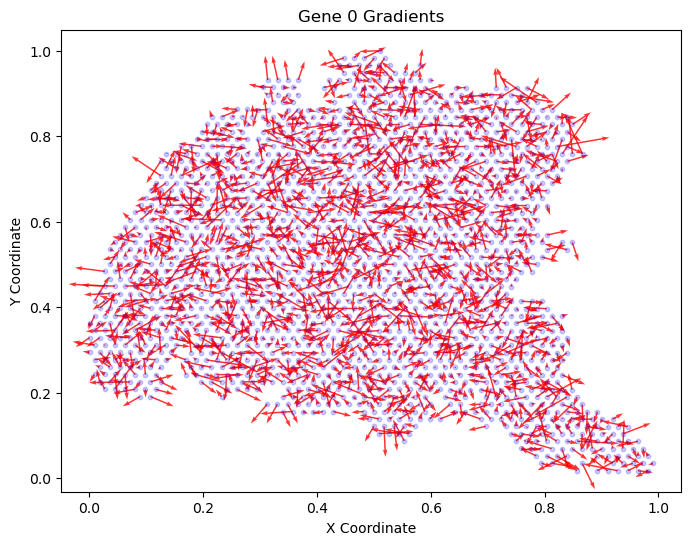

In [170]:
plot_gradients_quiver(valid_coords, gradient_x, gradient_y, gene_idx=0)

In [171]:
for gene_idx in range(output.shape[0]):
    gene_values = output[gene_idx, :]

    # Calculate the 75th percentile threshold for each gene
    expression_threshold = np.percentile(gene_values, 75)

    # Set values below the threshold to zero
    gene_values[gene_values < expression_threshold] = 0

print("Modified Output Shape:", output.shape)

Modified Output Shape: (10607, 1937)


In [172]:
valid_coords_th, gradient_x_th, gradient_y_th = compute_spatial_gradients_with_coords(output, X_norm)

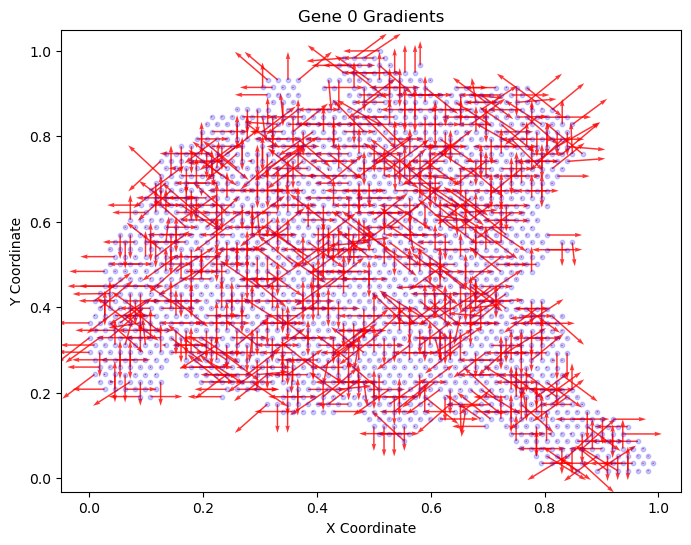

In [173]:
plot_gradients_quiver(valid_coords_th, gradient_x_th, gradient_y_th, gene_idx=0)